# Лабораторная работа №3: Свойства оценок, полученных методом моментов 

**Цели и задачи л/р**:  

1. Реализовать метод моментов к равномерному распределению (в качестве
   параметров выбрать левую и правую границы распределения). Использовать в
   качестве генерального распределения равномерное распределение от 0 до 1.
   Построить график зависимости значения оценок от величины выборки.
2. Реализовать обобщенный метод  моментов к равномерному распределению (в
   качестве параметров также выбрать левую и правую границы распределения).
   Использовать в качестве генерального распределения также равномерное
   распределение от 0 до 1. Построить график зависимости значения оценок от
   величины выборки (при участии в методе 3, 5, 7 моментов).
   Предложить веса для обобщенного метода моментов, позволяющие снизить дисперсию 
   получаемых оценок по сравнению с классическим методом моментов.
3. Построить график зависимости среднеквадратического отклонения перечисленных в
   пп. 1 и 2 оценок от размера выборки. Для оценки среднеквадратического отклонения
   использовать $10^3$ выборок. Сделать выводы.
4. Выполнить пункты 1-3 для экспоненциального распределения.
   https://ru.wikipedia.org/wiki/Экспоненциальное_распределение

In [1]:
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from tqdm.contrib.concurrent import process_map

/opt/pypy/lib/pypy3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLE_SIZES = sorted(
    [10**p for p in range(1, 5)]
    + [3 * 10**p for p in range(1, 4)] # 3 -> nice middle on log-scaled axis
)
UNIFORM_LOW = 0
UNIFORM_HIGH = 1
N_EXPERIMENTS = 1_000

## 1. Метод моментов для равномерного распределения
Уравнения для вычисления моментов:
$$
\begin{cases}
\mu_1^* = \cfrac{1}{n}\sum_{i=1}^{n}x \\
\mu_2^* = \cfrac{1}{n}\sum_{i=1}^{n}x^2
\end{cases}
$$

k-я моментная функция: $\mu_k[r]=\int^{+\infty}_{-\infty}x^k\cdot\varphi_r(x, b_1, ... b_k)dx = g_k(b_1,...b_k)$

Для равномерного распределения $X \sim U_{b_1,b_2}$:
$$
\begin{cases}
\mu_1^* = \cfrac{b_1^* + b_2^*}{2}; \\
\mu_2^* = \cfrac{(b_2^*)^3 - (b_1^*)^3}{3\cdot(b_2^*-b_1^*)} = \cfrac{(b_2^*)^2 + b_2b_1 + (b_1^*)^2}{3}
\end{cases}
$$

Выразим $b_1^*$ и $b_2^*$:

$$
\begin{cases}
b_1^* = \mu_1^* - \sqrt{3\cdot\mu_2^* - 3\cdot(\mu_1^*)^2}; \\
b_2^* = \mu_1^* + \sqrt{3\cdot\mu_2^* - 3\cdot(\mu_1^*)^2}
\end{cases}



In [25]:
def uniform_moments(sample):
    m1 = np.mean(sample)
    m2 = np.mean(sample**2)

    b1 = m1 - np.sqrt(3 * m2 - 3 * m1 ** 2)
    b2 = m1 + np.sqrt(3 * m2 - 3 * m1 ** 2)

    return b1, b2

In [26]:
def experiment_uniform_mm(args):
    n, i = args
    sample = np.random.uniform(size=n, low=UNIFORM_LOW, high=UNIFORM_HIGH)
    b1, b2 = uniform_moments(sample)
    return [n, b1, b2]

In [ ]:
args_uniform = list(itertools.product(SAMPLE_SIZES, range(N_EXPERIMENTS)))
rs = process_map(experiment_uniform_mm, args_uniform, chunksize=1)

100%|██████████| 7000/7000 [00:17<00:00, 410.30it/s]


In [ ]:
df = pd.DataFrame(rs, columns=("n", "b1", "b2"))
df

,n,b1,b2
0,10,-0.033074,1.011700
1,10,-0.033074,1.011700
2,10,-0.033074,1.011700
3,10,-0.033074,1.011700
4,10,-0.033074,1.011700
...,...,...,...
6995,10000,0.003868,0.995902
6996,10000,0.000200,0.994941
6997,10000,0.002650,1.002096
6998,10000,0.001559,1.005664


In [ ]:
df.to_csv("lab-3/uniform_mm_1.csv", index=False)

In [29]:
df_uniform_mean = df.groupby("n").mean()
df_uniform_std = df.groupby("n").std()
sizes = df["n"].unique()

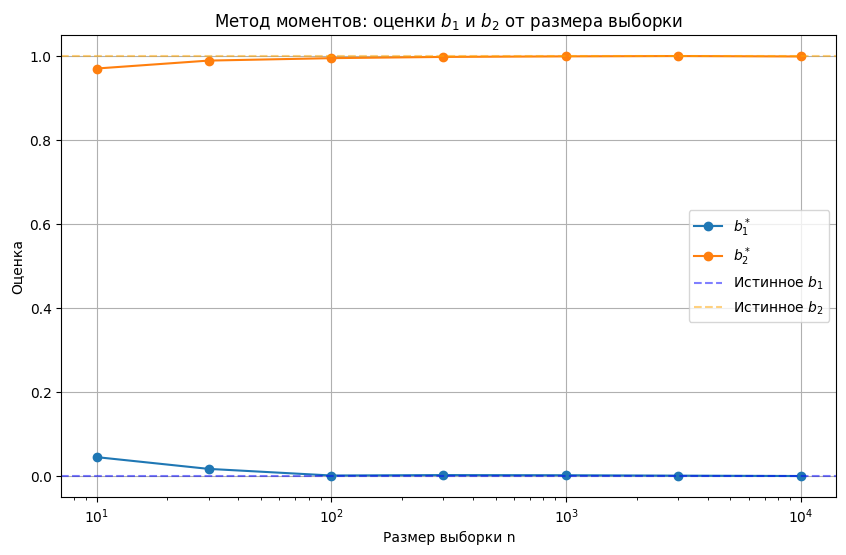

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, df_uniform_mean["b1"], marker="o", label="$b_1^*$")
plt.plot(sizes, df_uniform_mean["b2"], marker="o", label="$b_2^*$")
plt.axhline(UNIFORM_LOW, color="blue", linestyle="--", alpha=0.5, label="Истинное $b_1$")
plt.axhline(UNIFORM_HIGH, color="orange", linestyle="--", alpha=0.5, label="Истинное $b_2$")
plt.xscale("log")
plt.xlabel("Размер выборки n")
plt.ylabel("Оценка")
plt.title("Метод моментов: оценки $b_1$ и $b_2$ от размера выборки")
plt.legend()
plt.grid(True)

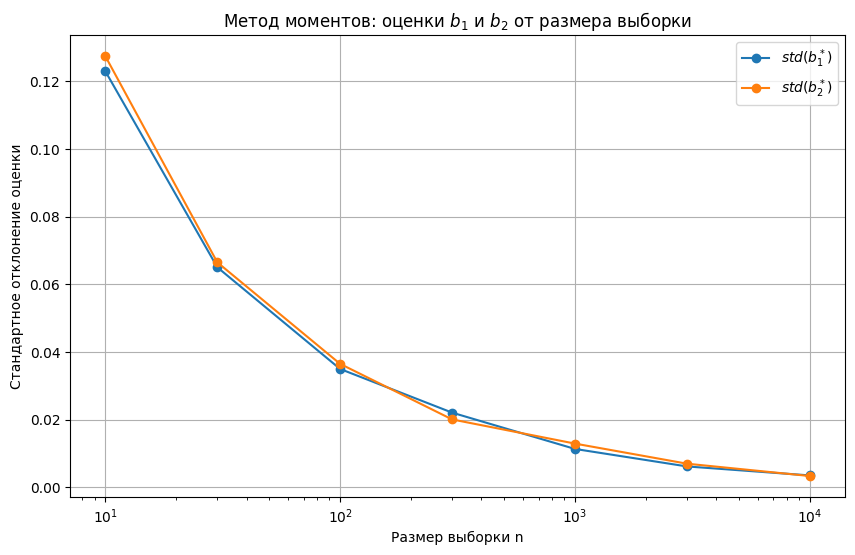

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, df_uniform_std["b1"], marker="o", label="$std(b_1^*)$")
plt.plot(sizes, df_uniform_std["b2"], marker="o", label="$std(b_2^*)$")
plt.xscale("log")
plt.xlabel("Размер выборки n")
plt.ylabel("Стандартное отклонение оценки")
plt.title("Метод моментов: оценки $b_1$ и $b_2$ от размера выборки")
plt.legend()
plt.grid(True)

## 2. Обобщенный метод моментов


In [45]:
def uniform_gmm(sample, k, weights):
    sample_moments = np.array([np.mean(sample ** j) for j in range(1, k + 1)])

    def loss(params):
        b1, b2 = params

        def uniform_momemnt(a, b, k):
            return (b ** (k + 1) - a ** (k + 1)) / ((k + 1) * (b - a))

        uniform_moments = np.array([uniform_momemnt(b1, b2, j) for j in range(1, k + 1)])
        return np.sum(weights * (uniform_moments - sample_moments) ** 2)

    init_params = [sample.min(), sample.max()]
    optimum = scipy.optimize.minimize(loss, init_params, method="BFGS") # method="BFGS"
    opt_params = optimum.x
    return opt_params

In [ ]:
def weights_harmonic(k, pow=1):
    return np.array([1 / j**pow for j in range(1, k + 1)])

def experiment_uniform_gmm(args):
    (n, ks), hp, i = args
    sample = np.random.uniform(size=n, low=UNIFORM_LOW, high=UNIFORM_HIGH)
    params = [
        uniform_gmm(sample, k, weights=weights_harmonic(k, pow=hp))
        for k in ks
    ]
    return list(zip(ks, itertools.repeat(n), itertools.repeat(hp), [p[0] for p in params], [p[1] for p in params]))

In [52]:
SAMPLE_SIZES_GMM = [100, 1000, 10000]
K = [3, 5, 7]
HARMONIC_POW = [0, 2, 5]
uniform_gmm_args = list(
    itertools.product(
        zip(SAMPLE_SIZES_GMM, itertools.repeat(K)), HARMONIC_POW, range(N_EXPERIMENTS)
    )
)
pss = process_map(experiment_uniform_gmm, uniform_gmm_args, chunksize=1)

100%|██████████| 9000/9000 [05:53<00:00, 25.43it/s] 


In [53]:
params = [p for ps in pss for p in ps ]
params_df = pd.DataFrame(params, columns=("k", "n", "hp", "b1", "b2"))
params_df

,k,n,hp,b1,b2
0,3,100,1,0.062488,1.063587
1,5,100,1,0.076660,1.052182
2,7,100,1,0.085308,1.045860
3,3,100,1,0.062488,1.063587
4,5,100,1,0.076660,1.052182
...,...,...,...,...,...
26995,5,10000,5,0.004598,0.993244
26996,7,10000,5,0.004586,0.993256
26997,3,10000,5,-0.001522,0.998428
26998,5,10000,5,-0.003892,1.000753


In [ ]:
params_df.to_csv("lab-3/uniform_gmm_hp.csv", index=False)

In [ ]:
params_df = pd.read_csv("lab-3/uniform_gmm_hp.csv")

In [55]:
sizes = sorted(params_df["n"].unique())
ks = params_df["k"].unique()
hps = params_df["hp"].unique()

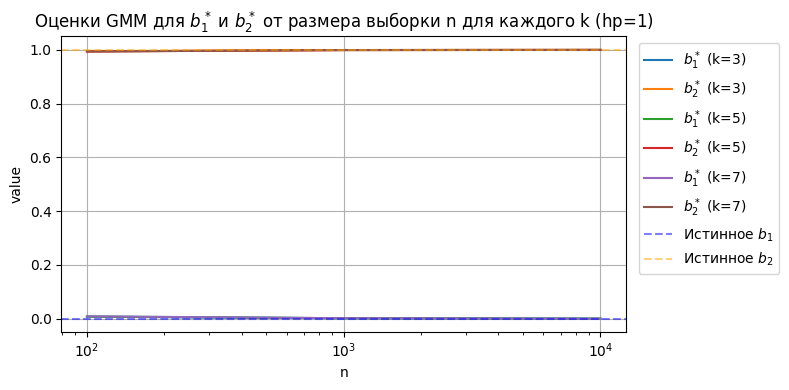

In [72]:
hp = hps[0]

plt.figure(figsize=(8, 4))

for k_val in ks:
    sub = (
        params_df[(params_df["k"] == k_val) & (params_df["hp"] == hp)]
        .sort_values("n")
        .groupby("n")
        .mean()
    )
    plt.plot(sizes, sub["b1"], label=f"$b_1^*$ (k={k_val})")
    plt.plot(sizes, sub["b2"], label=f"$b_2^*$ (k={k_val})")

plt.axhline(UNIFORM_LOW, color='blue', linestyle='--', alpha=0.5, label='Истинное $b_1$')
plt.axhline(UNIFORM_HIGH, color='orange', linestyle='--', alpha=0.5, label='Истинное $b_2$')
plt.xscale("log")
plt.xlabel("n")
plt.ylabel("value")
plt.title(f"Оценки GMM для $b_1^*$ и $b_2^*$ от размера выборки n для каждого k ({hp=:d})")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.grid(True)

plt.tight_layout()
plt.show()

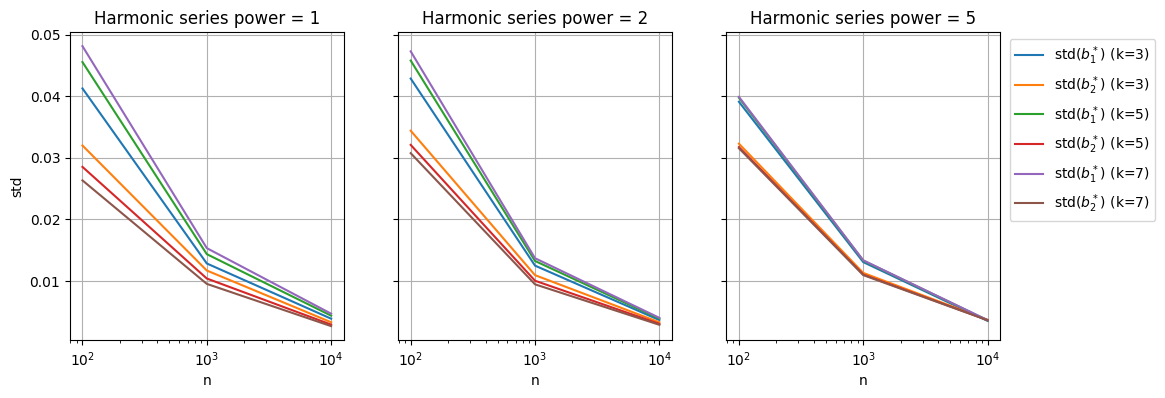

In [93]:
n = len(hps)
figsize = (4, 4)
fig, axs = plt.subplots(
    1, n, figsize=(figsize[0] * n, figsize[1]), squeeze=False, sharey=True
)

for i, hp in enumerate(hps):
    ax = axs[0, i]

    for k_val in ks:
        sub = (
            params_df[(params_df["k"] == k_val) & (params_df["hp"] == hp)]
            .sort_values("n")
            .groupby("n")
            .std()
        )
        ax.plot(sizes, sub["b1"], label=f"std($b_1^*$) (k={k_val})")
        ax.plot(sizes, sub["b2"], label=f"std($b_2^*$) (k={k_val})")

    ax.grid(True)
    ax.set_xscale("log")
    ax.set_xlabel("n")
    ax.set_title(f"Harmonic series power = {hp:d}")

axs[0, -1].legend(bbox_to_anchor=(1.01, 1), loc="upper left")
axs[0, 0].set_ylabel("std")
plt.show()

## 3. Метод моментов для экспоненциального распределения

Для экспоненциального распределения $X \sim \mathrm{Exp}_{\lambda}$

$$
\mu_1 = \cfrac{1}{\lambda}
$$

In [ ]:
def exponential_moments(sample):
    pass

In [ ]:
def experiment_exponential_mm(args):
    pass